In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from CLEARview import lattice, aperture, elements, opticsUtils, plot
import pandas as pd

In [2]:
# Define useful constants
c = 2.998e8        # [ms^-1] Speed of light
q = 1.602e-19      # [C] particle charge

In [3]:
# Relativistic parametres 
P0 = 200.0                    #[MeV]
m0c2 = 511e-03                #[MeV]
E0 = np.sqrt(m0c2**2 + P0**2) #[MeV]


# Initial twiss parametres 
N = 200         # Number of particles
epsn_x = 10.0   #[um]
epsn_y = 10.0   #[um]

# Find geometrical emittance
epsg_x = opticsUtils.get_eps_g(epsn_x,E0) 
epsg_y = opticsUtils.get_eps_g(epsn_y,E0) 

# Constraints in Plasma lens
#sigma_PL = 0.2e-03     #[m]
alpha_PL = 0.0

# Initial beta and alpha in the position of the Plasma lens
beta0x = 0.50
alpha0x = alpha_PL
beta0y = 0.50
alpha0y = alpha_PL

x0 = 0.0  #[mm]
y0 = 0.0  #[1e-3]
xp0 = 0.0 #[mm]
yp0 = 0.0 #[1e-3]

In [4]:
# Find the Twiss parametres from a distribution, in case it becomes useful

def Twiss(x,xp): 
    cov = np.cov(x, xp)
    erms = np.sqrt(np.linalg.det(cov))
    beta = cov[0,0]/erms
    alfa = -cov[0,1]/erms
    gamma = cov[1,1]/erms
    return cov, erms, beta, alfa, gamma

## Optimize for focus points [18.1815, 19.275]:

First optimization gives:
I = 60.10921832969479 [A]
k = 5.045681287224999 [1/mm^2]
Second optimization using I = 60.10921832969479 [A] (at symmetry point 18.1815) gives:
I1 = 97.21031470154273 [A],  I2 = 143.13091148495147 [A], I3 = 97.21030917810364 [A]


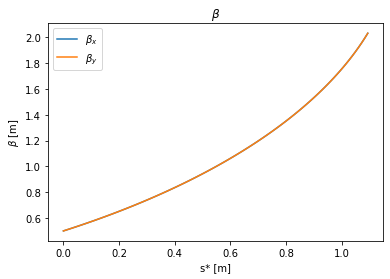

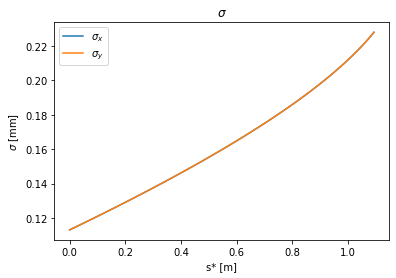

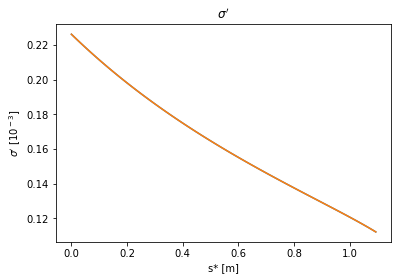

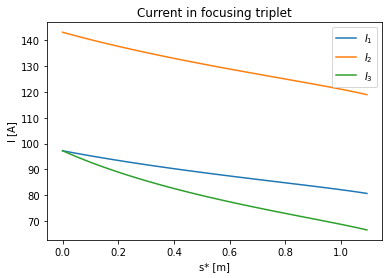

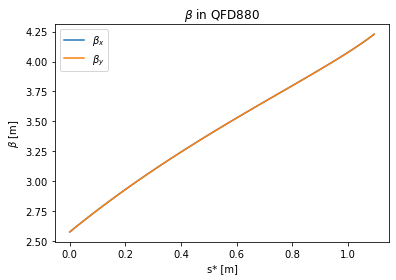

In [24]:
# Set up lattice
from CLEARview import clearST_survey0_tfs

def lattice(focus): 
    # Fix the setup of the quadrupoles
    latticeCLEAR = clearST_survey0_tfs.buildLattice(P0, doFinalize=False)
    sPLE = latticeCLEAR.getElemS('PLE0800M') # Get the position of the middle of the plasmalens
    latticeCLEAR.implicitSeq_removeElem('BTV0800') # Remove to avoid overlapping elements when adding PLE
    latticeCLEAR.implicitSeq_removeElem('CA.DHJ0840') # Remove kicker magnet from the setup
    latticeCLEAR.implicitSeq_addElem(elements.CLEAR_Q(0.0, P0), 'QFD0860', 16.2625, refer='end', referFrom=None) # Add focusing magnet
    latticeCLEAR.implicitSeq_addElem(elements.Marker(),'P', sPLE-0.01) #Mark the start of the plasmalens
    #latticeCLEAR.implicitSeq_addElem(elements.Marker(), 's* = 0', 18.1815)
    # Remove some markers for a simpler setup (easier to read the plot)
    #latticeCLEAR.implicitSeq_removeElem('CA.PLC0800M')
    latticeCLEAR.implicitSeq_removeElem('CA.QS0870')
    latticeCLEAR.implicitSeq_removeElem('CA.BPM0890')
    latticeCLEAR.implicitSeq_removeElem('CA.CLEAR$END')
    latticeCLEAR.implicitSeq_removeElem('CA.CLDUMP$START')
    latticeCLEAR.implicitSeq_removeElem('CA.VAW0915')
    latticeCLEAR.implicitSeq_removeElem('CA.ICT0930')
    latticeCLEAR.implicitSeq_removeElem('CLDUMP$END')
    latticeCLEAR.implicitSeq_removeElem('CA.BTV0910') # Fjernet pga jeg får trøbbel med optimeringen 
    latticeCLEAR.implicitSeq_removeElem('STLINE$END')
    #latticeCLEAR.implicitSeq_finalize()

    # Add markers for different focal points
    #latticeCLEAR.implicitSeq_addElem(elements.Marker(), 'Focus point', 18.1815) # Dette er fokuspunktet som er symmetrisk
    latticeCLEAR.implicitSeq_addElem(elements.Marker(), 'Focus point', focus)
    latticeCLEAR.implicitSeq_finalize()
    
    latticeCLEAR_PLE = latticeCLEAR.getSubLattice('PLE0800M')

    return latticeCLEAR_PLE

#-----------------------------------------------------------------------------------
# Twiss matrix for propagating
xt_init = np.asarray([beta0x, alpha0x, opticsUtils.getGamma(alpha0x,beta0x)])
yt_init = np.asarray([beta0y, alpha0y, opticsUtils.getGamma(alpha0y,beta0y)])

#-----------------------------------------------------------------------------------

# STARTING POINT (IMPORTANT: MUST BE "INSIDE" AREA WHERE YOU WANT TO PLOT - AKA AFTER BTV0910, BEFORE DUMP)
focus0 = 18.1815 

#-----------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------

latticeCLEAR_PLE = lattice(focus0)
focus_Index0 = latticeCLEAR_PLE.getTwissIdx("Focus point")# Hent ut indeks til fokuspunktet for første optimisering
quad880 = latticeCLEAR_PLE.getTwissIdx("QFD0880") # For saving the beam optics at the final quad

# First optimization ---------------------------------------------------------------
def compute_I(I1, I2, I3, findex1,lattice): 
    
    latticeCLEAR_PLE.elements['QFD0860'].update(I1, P0)
    latticeCLEAR_PLE.elements['QDD0870'].update(-I2, P0)
    latticeCLEAR_PLE.elements['QFD0880'].update(I3, P0)

    (s, xt, yt, xTra, yTra) = latticeCLEAR_PLE.computeTwiss(xt_init, yt_init)
    
    alphax = xt[1, findex1]
    alphay = yt[1, findex1]
    
    betax = xt[0, findex1]
    betay = yt[0, findex1]
    
    return (alphax**2 + alphay**2)*1000 + (betax-betay)**2 

def minFun(xin, findex1,lattice): 
    I1_ = xin[0]
    I2_ = 2 * xin[0]
    I3_ = xin[0]
    return compute_I(I1_, I2_, I3_, findex1,lattice)

I0 = [60]
bounds = [(0, 500)]

optRes = minimize(minFun, x0=I0, args= (focus_Index0, latticeCLEAR_PLE), bounds=bounds) 
#print(optRes)
I_opt = optRes.x[0]
print(f'First optimization gives:')
print(f"I = {I_opt} [A]")
EC_QD = 0.056; # excitation constant dB/dx/I = 0.056 [T/Am]
F_QD = opticsUtils.SI_c * 1e-6 * EC_QD;    
k = I_opt * F_QD / P0
print(f"k = {k} [1/mm^2]")

#------------------------------------------------------------------------------------------------
# Second optimization using results from first optimization: 

def minFun_opt(xin, findex, lattice):
        I1_, I2_, I3_ = xin
        latticeCLEAR_PLE.elements['QFD0860'].update(I1_, P0)
        latticeCLEAR_PLE.elements['QDD0870'].update(-I2_, P0)
        latticeCLEAR_PLE.elements['QFD0880'].update(I3_, P0)

        (s, xt, yt, xTra, yTra) = latticeCLEAR_PLE.computeTwiss(xt_init, yt_init)
        
        alphax = xt[1, findex]
        alphay = yt[1, findex]
        
        betax = xt[0, findex]
        betay = yt[0, findex]
 
        return (alphax**2 + alphay**2)*1000 + (betax-betay)**2 

I_final = [I_opt, 2*I_opt, I_opt]
#I_final = [100, 150, 100]
bounds = [(0, 500), (0, 500), (0, 500)]

optRes_final = minimize(minFun_opt, x0=I_final, args=(focus_Index0, latticeCLEAR_PLE), bounds=bounds) 
I1_opt_final = optRes_final.x[0]
I2_opt_final = optRes_final.x[1]
I3_opt_final = optRes_final.x[2]
print(f"Second optimization using I = {I_opt} [A] (at symmetry point 18.1815) gives:")
print(f"I1 = {I1_opt_final} [A],  I2 = {I2_opt_final} [A], I3 = {I3_opt_final} [A]")

#------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------

# FOR MULTIPLE FOCUS POINTS

I_start = [[I1_opt_final, I2_opt_final, I3_opt_final]]
focusarray = np.linspace(focus0, 19.2750, 100 )

#------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------

# Lists: 
betax_star     = []
betay_star     = []
s_star         = []
inv_beta       = []
I1             = []
I2             = []
I3             = []
sigma_x        = []
#sigma_xp       = []
sigma_y        = []
sigma_x_xp     = []
sigma_y_yp     = []
xDist_focus_x  = []
xDist_focus_xp = []
yDist_focus_y  = []
yDist_focus_yp = []
xDist_focus_b  = []
focus          = []

betax_880      = []
betay_880      = []

#------------------------------------------------------------------------------------------------

for i, f in enumerate(focusarray): 
    # Start values
    #print(f)
    focus.append(f)
    I = I_start[i]
    #print("Start values (I) for optimize: ", I)
    latticeCLEAR_PLE = lattice(f)
    focus_Index = latticeCLEAR_PLE.getTwissIdx("Focus point")
    #beta_index = latticeCLEAR_PLE.getTwissIdx("CA.PLC0800M")

    # OPTIMIZE
    optR = minimize(minFun_opt, I, args=(focus_Index, latticeCLEAR_PLE), bounds=bounds)
    
    I1_opt = optR.x[0]
    I2_opt = optR.x[1]
    I3_opt = optR.x[2]
    #print(f"I1_opt = {I1_opt}, I2_opt = {I2_opt}, I3_opt = {I3_opt}")
    
    # UPDATE LATTICE
    latticeCLEAR_PLE.elements['QFD0860'].update(I1_opt, P0)
    latticeCLEAR_PLE.elements['QDD0870'].update(-I2_opt, P0)
    latticeCLEAR_PLE.elements['QFD0880'].update(I3_opt, P0)
    
    #PROPAGATE
    (s,xt,yt, xTra,yTra, sSub,xtSub,ytSub,xTraSub,yTraSub) = latticeCLEAR_PLE.computeTwiss(xt_init,yt_init, subdivide=1e-3)
    

    #CALCULATE SIGMA X (and Y)
    sigmax = np.sqrt(xt[0, focus_Index]*epsg_x)
    sigmay = np.sqrt(yt[0, focus_Index]*epsg_y)
    
    # MAKE LISTS
    s_star.append(f-focus0) # Lage en lengdeliste til å plotte
    betax_star.append(xt[0, focus_Index])
    betay_star.append(yt[0, focus_Index])
    #inv_beta.append(1/betax_star[i])
    sigma_x.append(sigmax)
    sigma_y.append(sigmay)
    
    #Beta in the final quadrupole
    beta_x_q880 = xt[0, quad880]
    beta_y_q880 = yt[0, quad880]
    
    # CALCULATE SIGMA XP FROM SIGMA X
    sigma_xp = (sigmax / xt[0,focus_Index]) * np.sqrt(1 + xt[1, focus_Index]**2)
    sigma_x_xp.append(sigma_xp)
    sigma_yp = (sigmay / yt[0, focus_Index]) * np.sqrt(1+ yt[1, focus_Index]**2)
    sigma_y_yp.append(sigma_yp)
    
    I1.append(I1_opt)
    I2.append(I2_opt)
    I3.append(I3_opt)
    I_start.append([optR.x[0], optR.x[1], optR.x[2]])
    betax_880.append(beta_x_q880)
    betay_880.append(beta_y_q880)
#print(I_start)

#---------------------------------    
# Convert lists to array
s_plot = np.array(s_star)
betax_plot = np.array(betax_star)
betay_plot = np.array(betay_star)
#---------------------------------

#-----------------BETA AND SIGMA----------------------------------------

plt.figure()
plt.title(r'$\beta$')
plt.plot(s_plot, betax_plot, label=r'$\beta_x$')
plt.plot(s_plot, betay_plot, label=r'$\beta_y$')
plt.xlabel('s* [m]')
plt.ylabel(r'$\beta$ [m]')
plt.legend()
#plt.savefig(f'plots_obj1/Beta_x_{P0}.pdf')

plt.figure()
plt.title(f'$\sigma$ ')
plt.plot(s_plot, sigma_x, label=f'$\sigma_x$')
plt.plot(s_plot, sigma_y, label=f'$\sigma_y$')
plt.xlabel('s* [m]')
plt.ylabel(f'$\sigma$ [mm]')
plt.legend()
#plt.savefig(f'plots_obj1/sigma_x_{P0}.pdf')

plt.figure()
plt.title(f"$\sigma'$")
plt.plot(s_plot, sigma_x_xp, label=f"$\sigma'_x$")
plt.plot(s_plot, sigma_y_yp, label=f"$\sigma'_yp$")
plt.xlabel('s* [m]')
plt.ylabel(f"$\sigma'$ [10$^-$$^3$]")
#plt.savefig(f'plots_obj1/sigma_xp_{P0}.pdf')


#---------------------- PLOT CURRENTS ------------------------------------
plt.figure()
plt.title(f'Current in focusing triplet')
plt.plot(s_plot, I1, label=f'$I_1$')
plt.plot(s_plot, I2, label=f'$I_2$')
plt.plot(s_plot, I3, label=f'$I_3$')
plt.xlabel('s* [m]')
plt.ylabel('I [A]')
plt.legend()
#plt.savefig(f'plots_obj1/I1_I3_{P0}.pdf')

plt.figure()
plt.title(r'$\beta$ in QFD880')
plt.plot(s_plot, betax_880, label=r'$\beta_x$')
plt.plot(s_plot, betay_880, label=r'$\beta_y$')
plt.legend()
plt.xlabel('s* [m]')
plt.ylabel(r'$\beta$ [m]')
plt.show()
#opticsUtils.printLatticeOptics(latticeCLEAR_PLE, s, xt, yt, epsg_x,epsg_y, xTra, yTra)



## Optimize for focus points [17.400, 18.1815]:

In [25]:
focusarray_neg = np.linspace(focus0, 17.400, 100)
#print(focusarray_neg)

# Make lists for negative values
I_start_neg = [[I1_opt_final, I2_opt_final, I3_opt_final]]
I1_neg = []
I2_neg = []
I3_neg = []
s_star_neg = []
betax_star_neg = []
betay_star_neg = []
sigma_x_neg = []
sigma_x_xp_neg = []
sigma_y_neg = []
sigma_y_yp_neg = []
focus_neg   = []
betax_880_neg = []
betay_880_neg = []

for i, fn in enumerate(focusarray_neg): 
    # Start values
    #print(fn)
    focus_neg.append(fn)
    I = I_start_neg[i]
    #print("Start values (I) for optimize: ", I)
    latticeCLEAR_PLE = lattice(fn)
    focus_Index = latticeCLEAR_PLE.getTwissIdx("Focus point")
    beta_index = latticeCLEAR_PLE.getTwissIdx("PLE0800M")
    #beta_quad = latticeCLEAR_PLE.getTwissIdx("QFD0880")

    # OPTIMIZE
    optR = minimize(minFun_opt, I, args=(focus_Index, latticeCLEAR_PLE), bounds=bounds)
    
    I1_opt = optR.x[0]
    I2_opt = optR.x[1]
    I3_opt = optR.x[2]
    #print(f"I1_opt = {I1_opt}, I2_opt = {I2_opt}, I3_opt = {I3_opt}")
    
    # UPDATE LATTICE
    latticeCLEAR_PLE.elements['QFD0860'].update(I1_opt, P0)
    latticeCLEAR_PLE.elements['QDD0870'].update(-I2_opt, P0)
    latticeCLEAR_PLE.elements['QFD0880'].update(I3_opt, P0)
    
    #PROPAGATE
    (s,xt,yt, xTra,yTra, sSub,xtSub,ytSub,xTraSub,yTraSub) = latticeCLEAR_PLE.computeTwiss(xt_init,yt_init, subdivide=1e-3)
    
    #CALCULATE SIGMA X (and Y)
    sigmax = np.sqrt(xt[0, focus_Index]*epsg_x)
    sigmay = np.sqrt(yt[0, focus_Index]*epsg_y)
    
    # MAKE LISTS
    s_star_neg.append(fn-focus0) # Lage en lengdeliste til å plotte
    betax_star_neg.append(xt[0, focus_Index])
    betay_star_neg.append(yt[0, focus_Index])
    #inv_beta.append(1/betax_star[i])
    sigma_x_neg.append(sigmax)
    sigma_y_neg.append(sigmay)
    
    # CALCULATE SIGMA XP FROM SIGMA X
    sigma_xp_neg = (sigmax / xt[0,focus_Index]) * np.sqrt(1 + xt[1, focus_Index]**2)
    sigma_x_xp_neg.append(sigma_xp_neg)
    sigma_yp_neg = (sigmay / yt[0,focus_Index]) * np.sqrt(1 + yt[1, focus_Index]**2)
    sigma_y_yp_neg.append(sigma_yp_neg)
    
    I1_neg.append(I1_opt)
    I2_neg.append(I2_opt)
    I3_neg.append(I3_opt)
    I_start_neg.append([optR.x[0], optR.x[1], optR.x[2]])
    betax_880_neg.append(xt[0,quad880])
    betay_880_neg.append(yt[0,quad880])
    
print("Optimization finished")






Optimization finished


## Combine lists and arrays from optimizations (run this only once!!)

In [26]:
# Delete the focuspoint-value in order to concatenate with the other lists: 

del s_star_neg[0]
s_star_neg.reverse()
#print('Negative s:')
del I1_neg[0]
I1_neg.reverse()
#print('Negative I1:')
#print(I1_neg)
del I2_neg[0]
I2_neg.reverse()
del I3_neg[0]
I3_neg.reverse()
#print('Negative I3:')
#print(I3_neg)
del betax_star_neg[0]
betax_star_neg.reverse()
del betay_star_neg[0]
betay_star_neg.reverse()
del sigma_x_neg[0]
sigma_x_neg.reverse()
del sigma_x_xp_neg[0]
sigma_x_xp_neg.reverse()
del sigma_y_neg[0]
sigma_y_neg.reverse()
del sigma_y_yp_neg[0]
sigma_y_yp_neg.reverse()
del betax_880_neg[0]
betax_880_neg.reverse()
del betay_880_neg[0]
betay_880_neg.reverse()
del focus_neg[0]
focus_neg.reverse()

#plt.figure()
#plt.plot(s_star_neg, I1_neg, label='I1')
#plt.plot(s_star_neg, I3_neg, label='I3')
#plt.legend()
#plt.show()

# ---------- Join the lists together --------------------------------------------------

s_star_neg.extend(s_star)
total_s = np.array(s_star_neg)
I1_neg.extend(I1)
total_I1 = np.array(I1_neg)
I2_neg.extend(I2)
total_I2 = np.array(I2_neg)
I3_neg.extend(I3)
total_I3 = np.array(I3_neg)
betax_star_neg.extend(betax_star)
total_beta_x = np.array(betax_star_neg)
sigma_x_neg.extend(sigma_x)
total_sigma_x = np.array(sigma_x_neg)
sigma_x_xp_neg.extend(sigma_x_xp)
total_sigma_xp = np.array(sigma_x_xp_neg)
betay_star_neg.extend(betay_star)
total_beta_y = np.array(betay_star_neg)
sigma_y_neg.extend(sigma_y)
total_sigma_y = np.array(sigma_y_neg)
sigma_y_yp_neg.extend(sigma_y_yp)
total_sigma_yp = np.array(sigma_y_yp_neg)
betax_880_neg.extend(betax_880)
total_betax880 = np.array(betax_880_neg)
betay_880_neg.extend(betay_880)
total_betay880 = np.array(betay_880_neg)
focus_neg.extend(focus)
focus_total = focus_neg # NOT ARRAY, AS LIST PROPERTIES ARE NEEDED



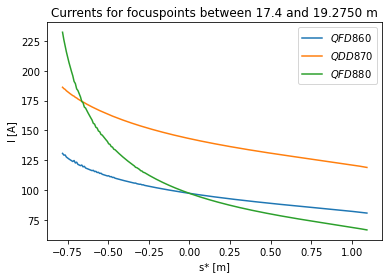

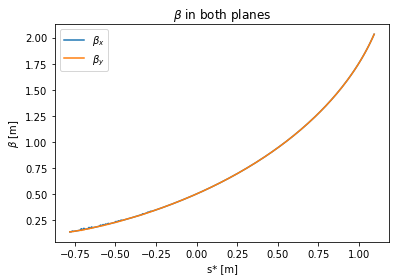

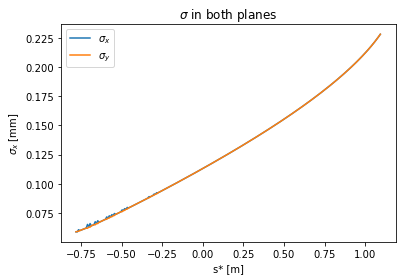

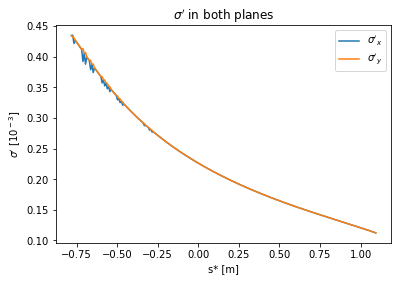

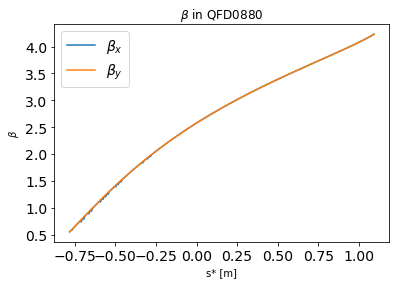

In [27]:
# ----------------------------- PLOT CURRENTS -----------------------------------------
plt.figure()
plt.plot(total_s, total_I1, label=f'$QFD860$')
plt.plot(total_s, total_I2, label=f'$QDD870$')
plt.plot(total_s, total_I3, label=f'$QFD880$')
plt.legend()
plt.xlabel(f's* [m]')
plt.ylabel(f'I [A]')
plt.title(f'Currents for focuspoints between 17.4 and 19.2750 m')
plt.savefig(f'plots_obj1/Obj1_Total_Currents_E{P0}.pdf')

#plt.figure()
#plt.plot(total_s, total_I2)
#plt.xlabel(f's* [m]')
#plt.ylabel(f'I [A]')
#plt.title(f'Currents QDD 870 up- and downstream of symmetrical focus point')

# ----------------------------- PLOT BETA AND SIGMA ------------------------------------

plt.figure()
plt.plot(total_s, total_beta_x, label=r'$\beta_x$')
plt.plot(total_s, total_beta_y, label=r'$\beta_y$')
plt.xlabel(f's* [m]')
plt.ylabel(r'$\beta$ [m]')
plt.title(r'$\beta$ in both planes')
#plt.savefig(f'plots_obj1/Betax_betay_E{P0}.pdf')
plt.legend()

plt.figure()
plt.plot(total_s, total_sigma_x, label=f'$\sigma_x$')
plt.plot(total_s, total_sigma_y, label=f'$\sigma_y$')
plt.xlabel(f's* [m]')
plt.ylabel(f'$\sigma_x$ [mm]')
plt.title(f'$\sigma$ in both planes')
plt.legend()
#plt.savefig(f'plots_obj1/Sigmax{P0}.pdf')

plt.figure()
plt.plot(total_s, total_sigma_xp, label=f"$\sigma'_x$")
plt.plot(total_s, total_sigma_yp, label=f"$\sigma'_y$")
plt.xlabel(f's* [m]')
plt.ylabel(f"$\sigma'$ [10$^-$$^3$]")
plt.title(f"$\sigma'$ in both planes")
plt.legend()
#plt.savefig(f'plots_obj1/Sigmaxp{P0}.pdf')
plt.show()

plt.figure()#figsize=(5.787376228033763*1.1, 5.787376228033763/1.1))
plt.title(r'$\beta$ in QFD0880')
plt.plot(total_s, total_betax880, label=r'$\beta_x$')
plt.plot(total_s, total_betay880, label=r'$\beta_y$')
plt.legend(fontsize=14)
plt.xlabel('s* [m]')
plt.ylabel(r'$\beta$')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.savefig('plots_obj1/beta_QFD880.pdf')
plt.show()

## Save to file

In [22]:
# Convert to DataFrame
df_I1 = pd.DataFrame(total_I1)
df_I2 = pd.DataFrame(total_I2)
df_I3 = pd.DataFrame(total_I3)
df_s = pd.DataFrame(total_s)
df_betax = pd.DataFrame(total_beta_x)
df_betay = pd.DataFrame(total_beta_y)
#df_focus = pd.DataFrame(FOCUS[0])
#df_alphax = pd.DataFrame(list_of_alphax)
#df_alphay = pd.DataFrame(list_of_alphay)
df_sigmax = pd.DataFrame(total_sigma_x)
df_sigmaxp = pd.DataFrame(total_sigma_xp)
df_sigmay = pd.DataFrame(total_sigma_y)
df_sigmayp = pd.DataFrame(total_sigma_yp)

# Save to different sheets in the same Excel file
with pd.ExcelWriter('LATTICE_NOAPL_FOCUSPOINTS.xlsx') as writer:
    df_s.to_excel(writer, sheet_name='list_of_s', index=False)
    #df_focus.to_excel(writer, sheet_name='Focus_points', index=False)
    df_I1.to_excel(writer, sheet_name='list_of_I1', index=False)
    df_I2.to_excel(writer, sheet_name='list_of_I2', index=False)
    df_I3.to_excel(writer, sheet_name='list_of_I3', index=False)
    df_betax.to_excel(writer, sheet_name='list_of_betaX', index=False)
    df_betay.to_excel(writer, sheet_name='list_of_betaY', index=False)
    #df_alphax.to_excel(writer, sheet_name='list_of_alphaX', index=False)
    #df_alphay.to_excel(writer, sheet_name='list_of_alphaY', index=False)
    df_sigmax.to_excel(writer, sheet_name='list_of_sigmaX', index=False)
    df_sigmaxp.to_excel(writer, sheet_name='list_of_sigmaXP', index=False)
    df_sigmay.to_excel(writer, sheet_name='list_of_sigmay', index=False)
    df_sigmayp.to_excel(writer, sheet_name='list_of_sigmayp', index=False)

print("Data saved to file")

Data saved to file


## Visualize beam propagation for any focus point

The closest value to focus point 19.2 is 19.197681818181817
Focus point (original coordinate) = 19.197681818181817 [m] 
Sigma prime for focus point 19.1977: 0.11930163551559365
s_star= 1.016181818181817


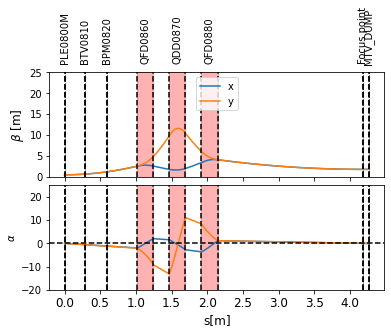

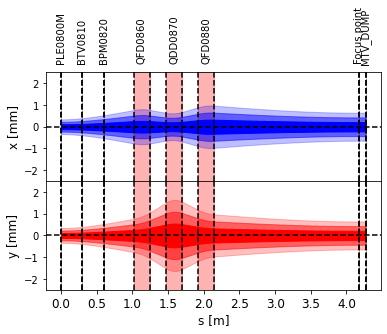

#  s[m] element_name         typeName            betax[m] betay[m]         alphax[m]        alphay[m] sigmax[mm] sigmay[mm]    x[mm]    y[mm]    dx/ds[1e-3]    dy/ds[1e-3]
###########################################################################################################################################################################
    0.0 START                -----                    0.5      0.5               0.0              0.0     0.1131     0.1131      0.0      0.0            0.0            0.0
    0.0 PLE0800M             Marker                   0.5      0.5               0.0              0.0     0.1131     0.1131      0.0      0.0            0.0            0.0
  0.292 drift_25             Drift                0.67053  0.67053            -0.584           -0.584    0.13097    0.13097      0.0      0.0            0.0            0.0
  0.292 BTV0810              Marker               0.67053  0.67053            -0.584           -0.584    0.13097    0.13097      0.0      0.

In [32]:
#from matplotlib.ticker import MultipleLocator, FormatStrFormatter
def latticeplot(focus): 
    
    target2 = focus
    closest_value2 = min(focus_total, key=lambda x: abs(x-target2))
    print(f"The closest value to focus point {target2} is {closest_value2}")
    index2 = focus_total.index(closest_value2)

    #I4_plot = plasma_values[index1]
    I1_plot = total_I1[index2]
    I2_plot = total_I2[index2]
    I3_plot = total_I3[index2]

    s_line = focus_total[index2]
    print(f"Focus point (original coordinate) = {s_line} [m] ")
    
        
    sigma_xp = total_sigma_xp[index2]
    print(f"Sigma prime for focus point {s_line:.4f}: {sigma_xp}")
    
    s_star_pos = s_line-18.1815
    print("s_star=", s_star_pos)
    
    # Twiss matrix for propagating
    xt_init = np.asarray([beta0x, alpha0x, opticsUtils.getGamma(alpha0x,beta0x)])
    yt_init = np.asarray([beta0y, alpha0y, opticsUtils.getGamma(alpha0y,beta0y)])
    
    latticeCLEAR_PLE = lattice(s_line)

    latticeCLEAR_PLE.elements['QFD0860'].update(I1_plot, P0)
    latticeCLEAR_PLE.elements['QDD0870'].update(-I2_plot, P0)
    latticeCLEAR_PLE.elements['QFD0880'].update(I3_plot, P0)
    #latticeCLEAR_PLE.elements['CA.PLE0800'].update(-I4_plot, P0)

    (s,xt,yt, xTra,yTra, sSub,xtSub,ytSub,xTraSub,yTraSub) = latticeCLEAR_PLE.computeTwiss(xt_init,yt_init, subdivide=1e-3)

    (ax_beta,ax_alpha) = plot.alphaBeta(s,xtSub,ytSub, sSub)
    plot.addElemsToPlot(ax_beta,latticeCLEAR_PLE)
    plot.addElemsToPlot(ax_alpha,latticeCLEAR_PLE)
    plot.addElemNamesToPlot(ax_beta,latticeCLEAR_PLE, ypos=1.1)
    ax_beta.set_ylim([0,25])
    ax_beta.set_ylabel(r'$\beta$ [m]', fontsize=12)
    #ax_beta.tick_params(labelsize=12)
    ax_alpha.set_ylim([-20,25])
    ax_alpha.set_xlabel(r'$\alpha$', fontsize=12)
    ax_alpha.set_xlabel('s[m]', fontsize=12)
    ax_alpha = plt.gca()
    ticks = np.arange(0, np.max(s), 0.5)
    plt.xticks(ticks, fontsize=12)
    #ax_alpha.xaxis.set_minor_locator(MultipleLocator(0.5))
    #ax_alpha.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    #ax_alpha.tick_params(labelsize=12)
    ax_beta.legend(loc='best')
    
    #plt.gcf().set_figwidth(5.787376228033763*1.0)
    #plt.gcf().set_figheight(5.787376228033763/2.5)
    #plt.savefig(f'plots_obj1/Alfa_beta/alphabeta_noplasma_focus{focus}_E{P0}.pdf', bbox_inches='tight')

    (ax1,ax2) = plot.sigmas(s,xtSub,ytSub,(epsg_x,epsg_y), xTraSub,yTraSub, sSub=sSub, equalY=True)
    plot.addElemsToPlot(ax1,latticeCLEAR_PLE)
    plot.addElemsToPlot(ax2,latticeCLEAR_PLE)
    plot.addElemNamesToPlot(ax1,latticeCLEAR_PLE, ypos=1.1)
    ax1.set_ylim([-2.5,2.5])
    ax1.set_ylabel('x [mm]', fontsize=12)
    #ax1.tick_params(labelsize=12)
    ax2.set_ylim([-2.5,2.5])
    ax2.set_ylabel('y [mm]', fontsize=12)
    ax2.set_xlabel('s [m]', fontsize=12)
    plt.xticks(ticks, fontsize=12)
    #ax2.tick_params(labelsize=12)
    #plt.gcf().set_figwidth(5.987376228033763*1.0)
    #plt.gcf().set_figheight(5.787376228033763/2.5)
    #plt.savefig(f'plots_obj1/Sigma_waist/waist_noplasma_focus{focus}_E{P0}.pdf', bbox_inches='tight')

    plt.show()

    return opticsUtils.printLatticeOptics(latticeCLEAR_PLE, s, xt, yt, epsg_x,epsg_y, xTra, yTra), [I1_plot, I2_plot, I3_plot]

EC_QD = 0.056; # excitation constant dB/dx/I = 0.056 [T/Am]
F_QD = opticsUtils.SI_c * 1e-6 * EC_QD;

# CALL FUNCTION BY USING FOCUS POINT COORDINATES FROM ORIGINAL LENGTH s OF FULL LATTICE
waist = latticeplot(19.2)

k1 = waist[1][0] * F_QD / P0
k2 = waist[1][1] * F_QD / P0
k3 = waist[1][-1] * F_QD / P0
print(f"The magnet strengths are k1 = {k1} T/m, k2 = {k2} T/m and k3 = {k3} T/m")
